In [1]:
import os
def get_datasets(path='../UCRArchive_2018'):
    dirs = os.listdir(path)
    return dirs

In [2]:
datasets = get_datasets()
print(datasets)

['Fungi', 'Yoga', 'ECGFiveDays', 'Wine', 'Symbols', 'SemgHandGenderCh2', 'FordB', 'SmallKitchenAppliances', 'SonyAIBORobotSurface2', 'MoteStrain', 'MixedShapesSmallTrain', 'Worms', 'UWaveGestureLibraryY', 'TwoLeadECG', 'GunPointAgeSpan', 'UMD', 'CinCECGTorso', 'PhalangesOutlinesCorrect', 'Adiac', 'DodgerLoopWeekend', 'CBF', 'PigCVP', 'DistalPhalanxTW', 'FaceFour', 'Crop', 'ElectricDevices', 'OliveOil', 'Chinatown', 'GunPointOldVersusYoung', 'HouseTwenty', 'UWaveGestureLibraryAll', 'DodgerLoopDay', 'DodgerLoopGame', 'Car', 'AllGestureWiimoteY', 'HandOutlines', 'BirdChicken', 'WordSynonyms', 'SmoothSubspace', 'SyntheticControl', 'BME', 'UWaveGestureLibraryZ', 'TwoPatterns', 'FordA', 'FiftyWords', 'UWaveGestureLibraryX', 'SemgHandMovementCh2', 'FaceAll', 'FreezerSmallTrain', 'ProximalPhalanxTW', 'PickupGestureWiimoteZ', 'DistalPhalanxOutlineAgeGroup', 'Meat', 'MixedShapesRegularTrain', 'AllGestureWiimoteX', 'FacesUCR', 'InsectEPGRegularTrain', 'NonInvasiveFetalECGThorax1', 'ECG200', 'Beef

In [3]:
dataset = datasets[6]
dataset='OSULeaf'
print(dataset)

OSULeaf


In [4]:
import numpy as np
data = np.load('./datasets/%s.npy' % dataset, allow_pickle=True).item()
value = data['data']

In [5]:
value.shape

(442, 427)

In [6]:
def split_x_y(value, ratio=0.2):
    y_len = int(value.shape[1] * ratio)
    x_len = int(value.shape[1] - y_len)
    return value[:, : x_len], value[:, -y_len: ]

In [7]:
x, y = split_x_y(value, ratio=0.2)

In [8]:
x = x.reshape(x.shape[0], 1, x.shape[-1])
y = y.reshape(y.shape[0], 1, y.shape[-1])

In [9]:
x.shape, y.shape

((442, 1, 342), (442, 1, 85))

In [10]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
#         return self.relu(out)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, backcast_len, forecast_len, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        self.relu = nn.ReLU()
        self.backcast_len = backcast_len
        self.num_channels = num_channels
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        #layers += [nn.Linear(16 * 161, 24)]
        self.network = nn.Sequential(*layers)
        self.linear1 = nn.Linear(num_channels[-1] * backcast_len, forecast_len)
#         self.linear2 = nn.Linear(1024, 24)

    def forward(self, x):
        x = self.network(x)
#         print(x.shape)
        x = x.view(-1, self.num_channels[-1] * self.backcast_len)
#         print(x.shape)
        x = self.linear1(x)
#         x = self.linear2(x)
#         print(x.shape)
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
net = TemporalConvNet(num_inputs=1, backcast_len=x.shape[-1], forecast_len=y.shape[-1], num_channels=[4, 8, 16]).to(device)

In [13]:
class QuantileLoss(nn.Module):
    ## From: https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629

    def __init__(self, quantiles):
        ##takes a list of quantiles
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds
            losses.append(
                torch.max(
                   (q-1) * errors, 
                   q * errors
            ).unsqueeze(1))
        loss = torch.mean(
            torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [14]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torch import optim
import time

In [15]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import numpy as np
import pandas as pd
from scipy import signal
import time

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(353, 1, 342) (353, 1, 85) (89, 1, 342) (89, 1, 85)


In [17]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [18]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[2])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])
print(y_train.shape, y_test.shape)

torch.Size([353, 85]) torch.Size([89, 85])


In [19]:
dataset_train = Data.TensorDataset(x_train, y_train)
loader = Data.DataLoader(dataset=dataset_train, batch_size=1024, shuffle=True, num_workers=2)

In [20]:
batch_num = 0
for step, (batch_x, batch_y) in enumerate(loader):
    print('x size:', batch_x.shape, ', y size:', batch_y.shape)
    batch_num += 1
print('%d batches' % batch_num)

x size: torch.Size([353, 1, 342]) , y size: torch.Size([353, 85])
1 batches


In [21]:
criterion = QuantileLoss([0.1, 0.5, 0.9])
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)
train_losses, test_losses = [], []

In [22]:
def compute_MAPE(y_true, y_pred): 
    MAPE = torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100 #/ y_true.shape[0]
    return MAPE.item()

In [23]:
epochs = 100

for epoch in range(epochs):
    t_start = time.time()
    running_RMSE, running_MAPE = 0, 0
    
    for step, (batch_x, batch_y) in enumerate(loader):
        input_x = batch_x.to(device)
        y = batch_y.to(device)  
        
        optimizer.zero_grad()
        
        output_data = net(input_x)
        loss = criterion(output_data, y)
        
        MAPE = compute_MAPE(output_data, y)
        #losses.append(MAPE)

        loss.backward()
        optimizer.step()
        
        running_RMSE += loss.item()# ** 0.5
        running_MAPE += MAPE
        #print('step=%d, loss=%.2f' % (step+1, running_loss/(step+1) ))
    train_losses.append(running_RMSE / batch_num)
    
    test_losses.append(criterion(net(x_test.to(device)), y_test.to(device)).item() )# ** 0.5)
    t_end = time.time()
    
    print('\repoch=%d, loss=%.6f, MAPE=%.6f%%, time=%.2fs per epoch      ' \
          % (epoch+1, running_RMSE / batch_num, running_MAPE / batch_num, t_end-t_start), end='')


epoch=100, loss=0.643836, MAPE=1021.404907%, time=0.25s per epoch      

In [24]:
def normalized_quantile_loss(x, y, net, q=0.5):
    ## From: https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629
    y_hat = net(x.to(device))
    y = y.to(device)
    
    QL = 2.0 * torch.sum(
                torch.abs(
                    (y_hat - y)
                    * ((y_hat >= y).float() - q)
                )
         )
    norm = torch.sum(torch.abs(y))
    if norm > 0:
        return QL / norm
    else:
        return QL / torch.sum(torch.abs(y_hat))
    return QL / norm

In [25]:
def tensor2numpy(data):
    return torch.Tensor.cpu(data.detach()).numpy()

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

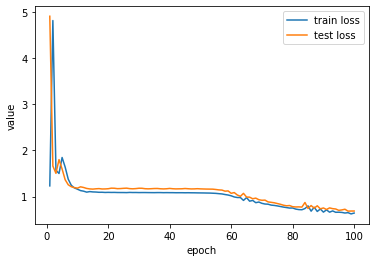

In [27]:
plt.figure()
dloss = pd.DataFrame({'epoch': np.arange(1, len(train_losses)+1, 1), 'train_loss': train_losses, 'test_loss': test_losses})
sns.lineplot(x='epoch', y='train_loss', data=dloss, label='train loss')
sns.lineplot(x='epoch', y='test_loss', data=dloss, label='test loss')
plt.ylabel('value')
plt.legend()
plt.show()

In [28]:
p50 = normalized_quantile_loss(x_test, y_test, net, q=0.5).item()
p90 = normalized_quantile_loss(x_test, y_test, net, q=0.9).item()
print('p50:%.6f, p90:%.6f' % (p50, p90))

p50:0.546959, p90:0.585321


78


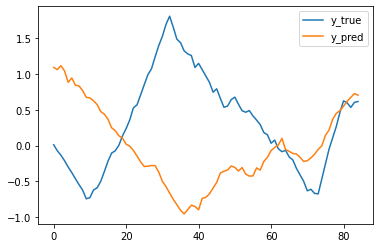

In [29]:
sid = np.random.randint(0, x_test.shape[0])
print(sid)
sx = x_test[sid: sid+1, :, :]
sy = tensor2numpy(y_test[sid])
sy_hat = tensor2numpy(net(sx.to(device)))[0]
plt.figure()
plt.plot(sy, label='y_true')
plt.plot(sy_hat, label='y_pred')
plt.legend()
plt.show()

In [30]:
y_pred = net(x_test.to(device))

In [31]:
def compute_QL(y_hat, y, q=0.5):
    y_hat = y_hat.to(device)
    y = y.to(device)
    
    QL = 2.0 * torch.sum(
                    torch.abs(
                        (y_hat - y)
                        * ((y_hat >= y).float() - q)
                    )
             )
    norm = torch.sum(torch.abs(y))
    if norm > 0:
        return QL / norm
    else:
        return QL / torch.sum(torch.abs(y_hat))
    return QL / norm

In [32]:
clips = y.shape[-1]
p50, p90 = [], []
for i in range(1, clips+1, 1):
    y_true_i = y_test[:, :i]
    y_pred_i = y_pred[:, :i]
    p50i = compute_QL(y_pred_i, y_true_i, q=0.5).item()
    p90i = compute_QL(y_pred_i, y_true_i, q=0.9).item()
    p50.append(p50i)
    p90.append(p90i)

In [33]:
p50

[0.4540574848651886,
 0.4521059989929199,
 0.46051499247550964,
 0.4702588617801666,
 0.47890233993530273,
 0.4851582646369934,
 0.4922885000705719,
 0.49904340505599976,
 0.5056713819503784,
 0.5123434662818909,
 0.5189569592475891,
 0.5245868563652039,
 0.5294949412345886,
 0.5329854488372803,
 0.5384929776191711,
 0.5409730672836304,
 0.5446703433990479,
 0.5491993427276611,
 0.5545347332954407,
 0.5596315264701843,
 0.5642250776290894,
 0.5692357420921326,
 0.5732206106185913,
 0.576815664768219,
 0.5803927183151245,
 0.5841520428657532,
 0.5876486897468567,
 0.5907475352287292,
 0.5930701494216919,
 0.5951464772224426,
 0.5971624851226807,
 0.5982259511947632,
 0.5995794534683228,
 0.6007177829742432,
 0.6017343997955322,
 0.6029697060585022,
 0.6042423248291016,
 0.6055654287338257,
 0.6069229245185852,
 0.6082558631896973,
 0.6096952557563782,
 0.6108420491218567,
 0.6120416522026062,
 0.613365650177002,
 0.6145727038383484,
 0.6160139441490173,
 0.6174516081809998,
 0.618669092

## p90

In [34]:
p90

[0.5274253487586975,
 0.4794359505176544,
 0.46413323283195496,
 0.45968127250671387,
 0.4881482422351837,
 0.48715871572494507,
 0.48719826340675354,
 0.4880537986755371,
 0.48913928866386414,
 0.4909437894821167,
 0.4938676059246063,
 0.49836066365242004,
 0.5037561058998108,
 0.5111211538314819,
 0.525342583656311,
 0.5320004224777222,
 0.5405965447425842,
 0.5478426814079285,
 0.5542463064193726,
 0.5598092079162598,
 0.5652186274528503,
 0.5711414813995361,
 0.575762152671814,
 0.5795010924339294,
 0.5843216180801392,
 0.59178227186203,
 0.5987126231193542,
 0.6043961048126221,
 0.609807014465332,
 0.6148350834846497,
 0.6211457848548889,
 0.6246702075004578,
 0.630007266998291,
 0.6348935961723328,
 0.6388606429100037,
 0.6427700519561768,
 0.6471782922744751,
 0.6508538722991943,
 0.6545122861862183,
 0.6579380035400391,
 0.6619430184364319,
 0.6651014089584351,
 0.6680868268013,
 0.6714069247245789,
 0.6742337346076965,
 0.6770874261856079,
 0.6795688271522522,
 0.6814717054367